In [3]:
# IMPORTS
from __future__ import print_function
import os
from io import BytesIO
import numpy as np
from functools import partial
import PIL.Image
from IPython.display import clear_output, Image, display, HTML

import tensorflow as tf

import time
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [4]:
#LOAD MODEL
model_fn = './inception5h/tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

In [5]:
#GET LAYERS, CHANNELS
layer_names = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
filtered_layer_names = [op.name for op in graph.get_operations() if op.type=='Conv2D' and ('import/' and
                        ("5x5" or "3x3" or "5x5"  or "conv2d") in op.name) and "bottleneck" not in op.name]

feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layer_names]

print(filtered_layer_names)

layers = []
channels = []
target_activations = []

for idx, layer_name in enumerate(layer_names):
    layer_name = str(layer_name[:-5] + ":0") #remove the "/conv" part, and add ":0"
    print(layer_name)
    layers.append(graph.get_tensor_by_name(layer_name))
    print(layers[idx].shape[3])
    for channel_idx in range(0,layers[idx].shape[3]):
        channel = layers[idx][:,:,:,channel_idx]
        channels.append(channel)
        target_activations.append(tf.reduce_mean(channel))

[u'import/mixed3a_5x5_pre_relu/conv', u'import/mixed3b_5x5_pre_relu/conv', u'import/mixed4a_5x5_pre_relu/conv', u'import/mixed4b_5x5_pre_relu/conv', u'import/mixed4c_5x5_pre_relu/conv', u'import/mixed4d_5x5_pre_relu/conv', u'import/mixed4e_5x5_pre_relu/conv', u'import/mixed5a_5x5_pre_relu/conv', u'import/mixed5b_5x5_pre_relu/conv']
import/conv2d0_pre_relu:0
64
import/conv2d1_pre_relu:0
64
import/conv2d2_pre_relu:0
192
import/mixed3a_1x1_pre_relu:0
64
import/mixed3a_3x3_bottleneck_pre_relu:0
96
import/mixed3a_3x3_pre_relu:0
128
import/mixed3a_5x5_bottleneck_pre_relu:0
16
import/mixed3a_5x5_pre_relu:0
32
import/mixed3a_pool_reduce_pre_relu:0
32
import/mixed3b_1x1_pre_relu:0
128
import/mixed3b_3x3_bottleneck_pre_relu:0
128
import/mixed3b_3x3_pre_relu:0
192
import/mixed3b_5x5_bottleneck_pre_relu:0
32
import/mixed3b_5x5_pre_relu:0
96
import/mixed3b_pool_reduce_pre_relu:0
64
import/mixed4a_1x1_pre_relu:0
192
import/mixed4a_3x3_bottleneck_pre_relu:0
96
import/mixed4a_3x3_pre_relu:0
204
import

In [106]:
layer_names = [op.name for op in graph.get_operations()]
layer_types = [op.type for op in graph.get_operations()]

for i in range(0,len(layer_names)):
    print("layer name: " + layer_names[i] + " layer type: " + str(layer_types[i]))


layer name: input layer type: Placeholder
layer name: sub/y layer type: Const
layer name: sub layer type: Sub
layer name: ExpandDims/dim layer type: Const
layer name: ExpandDims layer type: ExpandDims
layer name: import/input layer type: Placeholder
layer name: import/conv2d0_w layer type: Const
layer name: import/conv2d0_b layer type: Const
layer name: import/conv2d1_w layer type: Const
layer name: import/conv2d1_b layer type: Const
layer name: import/conv2d2_w layer type: Const
layer name: import/conv2d2_b layer type: Const
layer name: import/mixed3a_1x1_w layer type: Const
layer name: import/mixed3a_1x1_b layer type: Const
layer name: import/mixed3a_3x3_bottleneck_w layer type: Const
layer name: import/mixed3a_3x3_bottleneck_b layer type: Const
layer name: import/mixed3a_3x3_w layer type: Const
layer name: import/mixed3a_3x3_b layer type: Const
layer name: import/mixed3a_5x5_bottleneck_w layer type: Const
layer name: import/mixed3a_5x5_bottleneck_b layer type: Const
layer name: impo

layer name: Mean_780 layer type: Mean
layer name: strided_slice_781/stack layer type: Const
layer name: strided_slice_781/stack_1 layer type: Const
layer name: strided_slice_781/stack_2 layer type: Const
layer name: strided_slice_781 layer type: StridedSlice
layer name: Const_781 layer type: Const
layer name: Mean_781 layer type: Mean
layer name: strided_slice_782/stack layer type: Const
layer name: strided_slice_782/stack_1 layer type: Const
layer name: strided_slice_782/stack_2 layer type: Const
layer name: strided_slice_782 layer type: StridedSlice
layer name: Const_782 layer type: Const
layer name: Mean_782 layer type: Mean
layer name: strided_slice_783/stack layer type: Const
layer name: strided_slice_783/stack_1 layer type: Const
layer name: strided_slice_783/stack_2 layer type: Const
layer name: strided_slice_783 layer type: StridedSlice
layer name: Const_783 layer type: Const
layer name: Mean_783 layer type: Mean
layer name: strided_slice_784/stack layer type: Const
layer name:

layer name: strided_slice_1526 layer type: StridedSlice
layer name: Const_1526 layer type: Const
layer name: Mean_1526 layer type: Mean
layer name: strided_slice_1527/stack layer type: Const
layer name: strided_slice_1527/stack_1 layer type: Const
layer name: strided_slice_1527/stack_2 layer type: Const
layer name: strided_slice_1527 layer type: StridedSlice
layer name: Const_1527 layer type: Const
layer name: Mean_1527 layer type: Mean
layer name: strided_slice_1528/stack layer type: Const
layer name: strided_slice_1528/stack_1 layer type: Const
layer name: strided_slice_1528/stack_2 layer type: Const
layer name: strided_slice_1528 layer type: StridedSlice
layer name: Const_1528 layer type: Const
layer name: Mean_1528 layer type: Mean
layer name: strided_slice_1529/stack layer type: Const
layer name: strided_slice_1529/stack_1 layer type: Const
layer name: strided_slice_1529/stack_2 layer type: Const
layer name: strided_slice_1529 layer type: StridedSlice
layer name: Const_1529 layer 

layer name: strided_slice_2206 layer type: StridedSlice
layer name: Const_2206 layer type: Const
layer name: Mean_2206 layer type: Mean
layer name: strided_slice_2207/stack layer type: Const
layer name: strided_slice_2207/stack_1 layer type: Const
layer name: strided_slice_2207/stack_2 layer type: Const
layer name: strided_slice_2207 layer type: StridedSlice
layer name: Const_2207 layer type: Const
layer name: Mean_2207 layer type: Mean
layer name: strided_slice_2208/stack layer type: Const
layer name: strided_slice_2208/stack_1 layer type: Const
layer name: strided_slice_2208/stack_2 layer type: Const
layer name: strided_slice_2208 layer type: StridedSlice
layer name: Const_2208 layer type: Const
layer name: Mean_2208 layer type: Mean
layer name: strided_slice_2209/stack layer type: Const
layer name: strided_slice_2209/stack_1 layer type: Const
layer name: strided_slice_2209/stack_2 layer type: Const
layer name: strided_slice_2209 layer type: StridedSlice
layer name: Const_2209 layer 

layer name: strided_slice_2964/stack_2 layer type: Const
layer name: strided_slice_2964 layer type: StridedSlice
layer name: Const_2964 layer type: Const
layer name: Mean_2964 layer type: Mean
layer name: strided_slice_2965/stack layer type: Const
layer name: strided_slice_2965/stack_1 layer type: Const
layer name: strided_slice_2965/stack_2 layer type: Const
layer name: strided_slice_2965 layer type: StridedSlice
layer name: Const_2965 layer type: Const
layer name: Mean_2965 layer type: Mean
layer name: strided_slice_2966/stack layer type: Const
layer name: strided_slice_2966/stack_1 layer type: Const
layer name: strided_slice_2966/stack_2 layer type: Const
layer name: strided_slice_2966 layer type: StridedSlice
layer name: Const_2966 layer type: Const
layer name: Mean_2966 layer type: Mean
layer name: strided_slice_2967/stack layer type: Const
layer name: strided_slice_2967/stack_1 layer type: Const
layer name: strided_slice_2967/stack_2 layer type: Const
layer name: strided_slice_29

layer name: Mean_3676 layer type: Mean
layer name: strided_slice_3677/stack layer type: Const
layer name: strided_slice_3677/stack_1 layer type: Const
layer name: strided_slice_3677/stack_2 layer type: Const
layer name: strided_slice_3677 layer type: StridedSlice
layer name: Const_3677 layer type: Const
layer name: Mean_3677 layer type: Mean
layer name: strided_slice_3678/stack layer type: Const
layer name: strided_slice_3678/stack_1 layer type: Const
layer name: strided_slice_3678/stack_2 layer type: Const
layer name: strided_slice_3678 layer type: StridedSlice
layer name: Const_3678 layer type: Const
layer name: Mean_3678 layer type: Mean
layer name: strided_slice_3679/stack layer type: Const
layer name: strided_slice_3679/stack_1 layer type: Const
layer name: strided_slice_3679/stack_2 layer type: Const
layer name: strided_slice_3679 layer type: StridedSlice
layer name: Const_3679 layer type: Const
layer name: Mean_3679 layer type: Mean
layer name: strided_slice_3680/stack layer typ

layer name: Const_4363 layer type: Const
layer name: Mean_4363 layer type: Mean
layer name: strided_slice_4364/stack layer type: Const
layer name: strided_slice_4364/stack_1 layer type: Const
layer name: strided_slice_4364/stack_2 layer type: Const
layer name: strided_slice_4364 layer type: StridedSlice
layer name: Const_4364 layer type: Const
layer name: Mean_4364 layer type: Mean
layer name: strided_slice_4365/stack layer type: Const
layer name: strided_slice_4365/stack_1 layer type: Const
layer name: strided_slice_4365/stack_2 layer type: Const
layer name: strided_slice_4365 layer type: StridedSlice
layer name: Const_4365 layer type: Const
layer name: Mean_4365 layer type: Mean
layer name: strided_slice_4366/stack layer type: Const
layer name: strided_slice_4366/stack_1 layer type: Const
layer name: strided_slice_4366/stack_2 layer type: Const
layer name: strided_slice_4366 layer type: StridedSlice
layer name: Const_4366 layer type: Const
layer name: Mean_4366 layer type: Mean
layer

layer name: Const_5113 layer type: Const
layer name: Mean_5113 layer type: Mean
layer name: strided_slice_5114/stack layer type: Const
layer name: strided_slice_5114/stack_1 layer type: Const
layer name: strided_slice_5114/stack_2 layer type: Const
layer name: strided_slice_5114 layer type: StridedSlice
layer name: Const_5114 layer type: Const
layer name: Mean_5114 layer type: Mean
layer name: strided_slice_5115/stack layer type: Const
layer name: strided_slice_5115/stack_1 layer type: Const
layer name: strided_slice_5115/stack_2 layer type: Const
layer name: strided_slice_5115 layer type: StridedSlice
layer name: Const_5115 layer type: Const
layer name: Mean_5115 layer type: Mean
layer name: strided_slice_5116/stack layer type: Const
layer name: strided_slice_5116/stack_1 layer type: Const
layer name: strided_slice_5116/stack_2 layer type: Const
layer name: strided_slice_5116 layer type: StridedSlice
layer name: Const_5116 layer type: Const
layer name: Mean_5116 layer type: Mean
layer

layer name: strided_slice_5793/stack_1 layer type: Const
layer name: strided_slice_5793/stack_2 layer type: Const
layer name: strided_slice_5793 layer type: StridedSlice
layer name: Const_5793 layer type: Const
layer name: Mean_5793 layer type: Mean
layer name: strided_slice_5794/stack layer type: Const
layer name: strided_slice_5794/stack_1 layer type: Const
layer name: strided_slice_5794/stack_2 layer type: Const
layer name: strided_slice_5794 layer type: StridedSlice
layer name: Const_5794 layer type: Const
layer name: Mean_5794 layer type: Mean
layer name: strided_slice_5795/stack layer type: Const
layer name: strided_slice_5795/stack_1 layer type: Const
layer name: strided_slice_5795/stack_2 layer type: Const
layer name: strided_slice_5795 layer type: StridedSlice
layer name: Const_5795 layer type: Const
layer name: Mean_5795 layer type: Mean
layer name: strided_slice_5796/stack layer type: Const
layer name: strided_slice_5796/stack_1 layer type: Const
layer name: strided_slice_57

layer name: strided_slice_6530/stack_1 layer type: Const
layer name: strided_slice_6530/stack_2 layer type: Const
layer name: strided_slice_6530 layer type: StridedSlice
layer name: Const_6530 layer type: Const
layer name: Mean_6530 layer type: Mean
layer name: strided_slice_6531/stack layer type: Const
layer name: strided_slice_6531/stack_1 layer type: Const
layer name: strided_slice_6531/stack_2 layer type: Const
layer name: strided_slice_6531 layer type: StridedSlice
layer name: Const_6531 layer type: Const
layer name: Mean_6531 layer type: Mean
layer name: strided_slice_6532/stack layer type: Const
layer name: strided_slice_6532/stack_1 layer type: Const
layer name: strided_slice_6532/stack_2 layer type: Const
layer name: strided_slice_6532 layer type: StridedSlice
layer name: Const_6532 layer type: Const
layer name: Mean_6532 layer type: Mean
layer name: strided_slice_6533/stack layer type: Const
layer name: strided_slice_6533/stack_1 layer type: Const
layer name: strided_slice_65

layer name: Const_7196 layer type: Const
layer name: Mean_7196 layer type: Mean
layer name: strided_slice_7197/stack layer type: Const
layer name: strided_slice_7197/stack_1 layer type: Const
layer name: strided_slice_7197/stack_2 layer type: Const
layer name: strided_slice_7197 layer type: StridedSlice
layer name: Const_7197 layer type: Const
layer name: Mean_7197 layer type: Mean
layer name: strided_slice_7198/stack layer type: Const
layer name: strided_slice_7198/stack_1 layer type: Const
layer name: strided_slice_7198/stack_2 layer type: Const
layer name: strided_slice_7198 layer type: StridedSlice
layer name: Const_7198 layer type: Const
layer name: Mean_7198 layer type: Mean
layer name: strided_slice_7199/stack layer type: Const
layer name: strided_slice_7199/stack_1 layer type: Const
layer name: strided_slice_7199/stack_2 layer type: Const
layer name: strided_slice_7199 layer type: StridedSlice
layer name: Const_7199 layer type: Const
layer name: Mean_7199 layer type: Mean
layer

In [134]:
# TEST - GET PREDICTION

layer_names = [op.name for op in graph.get_operations() if op.type=='Softmax' and 'import/' in op.name]
#layer_names = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]

layer_name = layer_names[0]
layer_name = "import/output2"

print(layer_name)
#layer_name = str(layer_name[:-5] + ":0") #remove the "/conv" part, and add ":0"
layer_name = str(layer_name + ":0") #remove the "/conv" part, and add ":0"
print(layer_name)
tensor = graph.get_tensor_by_name(layer_name)
print(tensor)

target_activations = tensor

#img = np.random.uniform(size=(224,224,3)) + 100.0
img = load_image("/home/magyaba/UNI/DIPLOMAMUNKA/ILSVRC2012_img_val/ILSVRC2012_val_00050000.JPEG")
activations = sess.run(target_activations, {t_input:img})
activations

import/output2
import/output2:0
Tensor("import/output2:0", shape=(?, 1008), dtype=float32, device=/device:CPU:0)


array([[2.6063701e-05, 5.5567518e-05, 1.4288889e-04, ..., 2.6061787e-05,
        2.6064819e-05, 2.6063553e-05],
       [1.1787291e-05, 7.5461510e-05, 1.5134634e-04, ..., 1.1786415e-05,
        1.1787774e-05, 1.1787212e-05],
       [3.8253575e-06, 6.7313777e-05, 9.6792537e-05, ..., 3.8250728e-06,
        3.8255180e-06, 3.8253356e-06],
       ...,
       [1.0512800e-09, 1.0109955e-07, 1.2947408e-08, ..., 1.0512037e-09,
        1.0513261e-09, 1.0512740e-09],
       [1.3573810e-09, 6.8309078e-08, 1.8532976e-08, ..., 1.3572825e-09,
        1.3574404e-09, 1.3573731e-09],
       [1.0328166e-08, 2.0909830e-07, 1.7736924e-07, ..., 1.0327398e-08,
        1.0328599e-08, 1.0328107e-08]], dtype=float32)

In [6]:
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

In [8]:
def convert2time(time_sec):
    sec = time_sec%60
    minute = (time_sec/60)%60
    hour = (time_sec/3600)%60
    
    return str(hour) + ":" + str(minute) + ":" + str(sec)

In [109]:
#GET ACTIVATIONS

nbr_samples = 50000
nbr_classes = 1000
nbr_channels = len(channels)

saveFrequency = 100

#img_dir = os.path.join( "E:", "PPKE", "Diplomamunka","adatbazisok","ImageNet","ILSVRC2012_img_val")
img_dir = "/home/magyaba/UNI/DIPLOMAMUNKA/ILSVRC2012_img_val/"

all_activation = np.zeros((nbr_samples,nbr_channels))

img_idx=0

for filename in os.listdir(img_dir):
    start = time.time()
    img = load_image(os.path.join(img_dir,filename))
    if len(img.shape)!=3: # if not a color image
        img_idx +=1
        continue

    activations = sess.run(target_activations, {t_input:img})   
    all_activation[img_idx,:] = activations
    end = time.time()
    remaningTime = convert2time(int((end - start)*(nbr_samples-img_idx)))
    
    print("Image: " + str(img_idx+1) + "/" + str(nbr_samples) + "   Remaning time: " +  remaningTime,end="\r")

    if (img_idx%saveFrequency)==0 and img_idx!=0:
        np.savetxt("./activations/" +str(img_idx) + ".txt", all_activation[img_idx-saveFrequency:img_idx,:], delimiter=',')
    
    img_idx +=1

KeyboardInterrupt: 

In [119]:
#GET PREDICTIONS

nbr_samples = 50000

img_dir = "/home/magyaba/UNI/DIPLOMAMUNKA/ILSVRC2012_img_val/"
all_predictions = np.zeros((nbr_samples))

layer_names = [op.name for op in graph.get_operations() if op.type=='Softmax' and 'import/' in op.name]

layer_name = layer_names[2] #3rd softmax layer
print(layer_name)
layer_name = str(layer_name + ":0")
print(layer_name)
tensor = graph.get_tensor_by_name(layer_name)
print(tensor)

target_activations = tensor

img_idx=0

for filename in os.listdir(img_dir):  
    
    img_noise = np.random.uniform(size=(224,224,3)) + 100.0
    img = load_image(os.path.join(img_dir,filename))
    print(img.shape)

    if len(img.shape)!=3: # if not a color image
        img_idx +=1
        continue
    
    start = time.time()
    activations = sess.run(target_activations, {t_input:img_noise})
    end = time.time()
    print("sess run: " + str(end - start))
    print(activations.shape)
    for i in range(0,80):
        print(str(sum(activations[i,:])))
    print(str(activations))
    
    #all_predictions[img_idx] = activations
    plt.plot(np.matrix.transpose(activations))
    img_idx +=1
    input("kaja")

import/softmax2
import/softmax2:0
Tensor("import/softmax2:0", shape=(?, 1008), dtype=float32, device=/device:CPU:0)
(500, 420, 3)
sess run: 0.0299510955811
(1, 1008)
1.0000000853909796


IndexError: index 1 is out of bounds for axis 0 with size 1

(80, 1008)
(1008,)
774


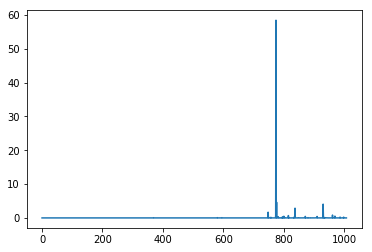

In [115]:

print(activations.shape)
sumactivations = activations.sum(axis=0)
print(sumactivations.shape)
print(np.argmax(sumactivations))
plt.plot(np.matrix.transpose(sumactivations))

In [76]:
activations.shape

(1, 1008)

In [51]:
print(all_activation[19877,:])
np.savetxt('19877tol.txt', all_activation[19877:,:], delimiter=',')

[-12.74092102  -6.56845713  -4.76647758 ...,  -3.17103529  -8.28925228
 -19.17745972]


In [4]:
#LOAD ACTIVATION ARRAYS
import numpy as np
a = np.loadtxt('19875ig.txt', delimiter=',')
print("Loading of the first 20K activations is done.")
b = np.loadtxt('19877tol.txt', delimiter=',')
print("Loading of all activations is done.")
all_activation = np.concatenate((a[:19877:],b[:,:]),axis=0) #the last two elements of a is all 0.
all_activation.shape

Loading of the first 20K activations is done.
Loading of all activations is done.


(50000, 7548)

In [17]:
all_activation_original = all_activation

In [6]:
#LOAD GROUND TRUTH LABELS and the class names
grountTruth = np.loadtxt('ILSVRC2012_validation_ground_truth.txt')
grountTruth.shape

with open('inception5h/imagenet_comp_graph_label_strings.txt') as f:
    classNames = f.read().splitlines() 

[513. 361. 364. 372. 782. 659. 297. 554. 361. 170.  13. 617. 104. 568.
 501. 954. 273. 398. 547. 949. 885.  13. 516. 106.  98. 836. 188. 753.
 935. 922. 824. 397. 599. 193. 563. 613. 318. 204. 749. 122. 483. 705.
 207. 649. 451. 171. 436. 983. 367. 996. 631. 606. 392.  57. 817. 734.
 171. 750. 498. 753.   2. 356. 999. 102. 596. 704. 399. 657. 118. 782.
  11. 893. 497. 401. 644. 291. 452.  14. 200. 817. 249. 164. 217. 306.
 456. 297. 202. 377. 914.  39. 809. 917.  31. 693. 267. 283. 305. 885.
 545. 922.]
[147   1 144 143 116 207   4  14  80 190   6 110  92  73  36  33 134 127
  37  79 128  20 204 146  81  60  96 193 105 159 167  72   8  71  84 194
  22  21  18  86  83  75  27  10  65   2  97  45 213 163 124  39 197 126
 125 182 179  53  51 142 171 139 115  26 120   7  17 137  56 183  11  57
  87  74  30  68 123  32 101 201  34   9 188 191  49  40  77 100  88 178
  38 151  78  23  55 186 131 196  19 117]


(array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 

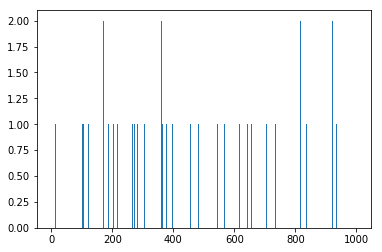

In [88]:
#GET MAXIMUM ACTIVATIONS OF A CHANNEL
import matplotlib.pyplot as plt

nbrMaxActivations = 100
channelNbr = 0

channelActivations = all_activation[:,channelNbr]
maxActivations = np.argsort(channelActivations)[-nbrMaxActivations:]

maxActivationClasses = grountTruth[maxActivations]
print(str(maxActivationClasses))
plt.hist(maxActivationClasses,bins=1000)

print(str(maxActivations))

hist = np.histogram(maxActivationClasses,bins=1000)
hist

In [15]:
#SHOW IMAGE

imageID = 2130
img_dir = "/home/magyaba/UNI/DIPLOMAMUNKA/ILSVRC2012_img_val/"

image_names = os.listdir(img_dir)
image_names = sorted(image_names)

img_path = img_dir + image_names[imageID]

label = classNames[int(grountTruth[imageID])]
print("Image class:" + label)

im = Image.open(img_path)
im.show()



Image class:green snake


In [159]:
#GET CLASS NAMES
classIndex = 773
print(classNames[classIndex])

knee pad


In [64]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, **kwargs)
    Plot lines and/or markers to the
    :class:`~matplotlib.axes.Axes`.  *args* is a variable length
    argument, allowing for multiple *x*, *y* pairs with an
    optional format string.  For example, each of the following is
    legal::
    
        plot(x, y)        # plot x and y using default line style and color
        plot(x, y, 'bo')  # plot x and y using blue circle markers
        plot(y)           # plot y using x as index array 0..N-1
        plot(y, 'r+')     # ditto, but with red plusses
    
    If *x* and/or *y* is 2-dimensional, then the corresponding columns
    will be plotted.
    
    If used with labeled data, make sure that the color spec is not
    included as an element in data, as otherwise the last case
    ``plot("v","r", data={"v":..., "r":...)``
    can be interpreted as the first case which would do ``plot(v, r)``
    using the default line style and color.
    
    If not used wi

In [3]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))
for idx in range(0,len(layers)):
    print('\n Feature layer: ' + str(layers[idx]) + ' nbr of channels: '+ str(feature_nums[idx]))


# Helper functions for TF Graph visualization

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def
  
def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Visualizing the network graph. Be sure expand the "mixed" nodes to see their 
# internal structure. We are going to visualize "Conv2D" nodes.
tmp_def = rename_nodes(graph_def, lambda s:"/".join(s.split('_',1)))
show_graph(tmp_def)

Number of layers 59
Total number of feature channels: 7548

 Feature layer: import/conv2d0_pre_relu/conv nbr of channels: 64

 Feature layer: import/conv2d1_pre_relu/conv nbr of channels: 64

 Feature layer: import/conv2d2_pre_relu/conv nbr of channels: 192

 Feature layer: import/mixed3a_1x1_pre_relu/conv nbr of channels: 64

 Feature layer: import/mixed3a_3x3_bottleneck_pre_relu/conv nbr of channels: 96

 Feature layer: import/mixed3a_3x3_pre_relu/conv nbr of channels: 128

 Feature layer: import/mixed3a_5x5_bottleneck_pre_relu/conv nbr of channels: 16

 Feature layer: import/mixed3a_5x5_pre_relu/conv nbr of channels: 32

 Feature layer: import/mixed3a_pool_reduce_pre_relu/conv nbr of channels: 32

 Feature layer: import/mixed3b_1x1_pre_relu/conv nbr of channels: 128

 Feature layer: import/mixed3b_3x3_bottleneck_pre_relu/conv nbr of channels: 128

 Feature layer: import/mixed3b_3x3_pre_relu/conv nbr of channels: 192

 Feature layer: import/mixed3b_5x5_bottleneck_pre_relu/conv nbr of

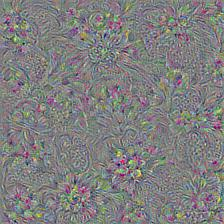

In [4]:


# Picking some internal layer. Note that we use outputs before applying the ReLU nonlinearity
# to have non-zero gradients for features with negative initial activations.
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 139 # picking some feature channel to visualize

# start with a gray image with a little noise
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def visstd(a, s=0.1):
    '''Normalize the image range for visualization'''
    return (a-a.mean())/max(a.std(), 1e-4)*s + 0.5

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

def render_naive(t_obj, img0=img_noise, iter_n=20, step=1.0):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!
    
    img = img0.copy()
    for i in range(iter_n):
        g, score = sess.run([t_grad, t_score], {t_input:img})
        
        #print(str(g))
        #input("next")
        
        # normalizing the gradient, so the same step size should work 
        g /= g.std()+1e-8         # for different layers and networks
        img += g*step
        print(score, end = ' ')
    clear_output()
    showarray(visstd(img))

render_naive(T(layer)[:,:,:,channel])